In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vipin20/transaction-data")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'transaction-data' dataset.
Path to dataset files: /kaggle/input/transaction-data


In [2]:
import pandas as pd
# Uploading the csv file
df=pd.read_csv(path+"/transaction_data.csv");
df.head()

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country
0,278166,6355745,Sat Feb 02 12:50:00 IST 2019,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom
1,337701,6283376,Wed Dec 26 09:06:00 IST 2018,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom
2,267099,6385599,Fri Feb 15 09:45:00 IST 2019,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France
3,380478,6044973,Fri Jun 22 07:14:00 IST 2018,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom
4,-1,6143225,Mon Sep 10 11:58:00 IST 2018,1733592,WASHROOM METAL SIGN,3,3.40,United Kingdom


In [3]:
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler,MinMaxScaler
import time
import numpy as np
from scipy import sparse
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
# checking the duplicates and removing them
df.info()

df['UserId'] = df['UserId'].replace(-1,1)  # keep your logic exactly as it is
df['TotalCost'] = df['NumberOfItemsPurchased'] * df['CostPerItem']

def clear_Description(description):
    description = str(description).lower()
    description = re.sub(r'[^a-zA-Z0-9 ]+', ' ', description)#ChatGPT assessted
    description = re.sub(r'\s+', ' ', description).strip()#ChatGPT assessted
    return description

df['Description'] = df['ItemDescription'].astype(str).apply(clear_Description)#ChatGPT assessted

# drop duplicates
df_new = df.drop_duplicates()

df_new = df_new.drop(columns=["ItemDescription","TransactionId"])

print('-----------------without duplicates-------------------')
df_new.info()

print('-----------------number of nulls Before----------------')
print(df_new.isna().sum())
print('-----------------number of nulls After----------------')
print(df_new.isna().sum())

# label encode Country
# le_country = LabelEncoder()
# df_new['Country'] = le_country.fit_transform(df_new['Country'])
# df_new['Country'] = df_new['Country'].astype(int)
# df_new.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1083818 entries, 0 to 1083817
Data columns (total 8 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   UserId                  1083818 non-null  int64  
 1   TransactionId           1083818 non-null  int64  
 2   TransactionTime         1083818 non-null  object 
 3   ItemCode                1083818 non-null  int64  
 4   ItemDescription         1080910 non-null  object 
 5   NumberOfItemsPurchased  1083818 non-null  int64  
 6   CostPerItem             1083818 non-null  float64
 7   Country                 1083818 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 66.2+ MB
-----------------without duplicates-------------------
<class 'pandas.core.frame.DataFrame'>
Index: 536572 entries, 0 to 1081501
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   U

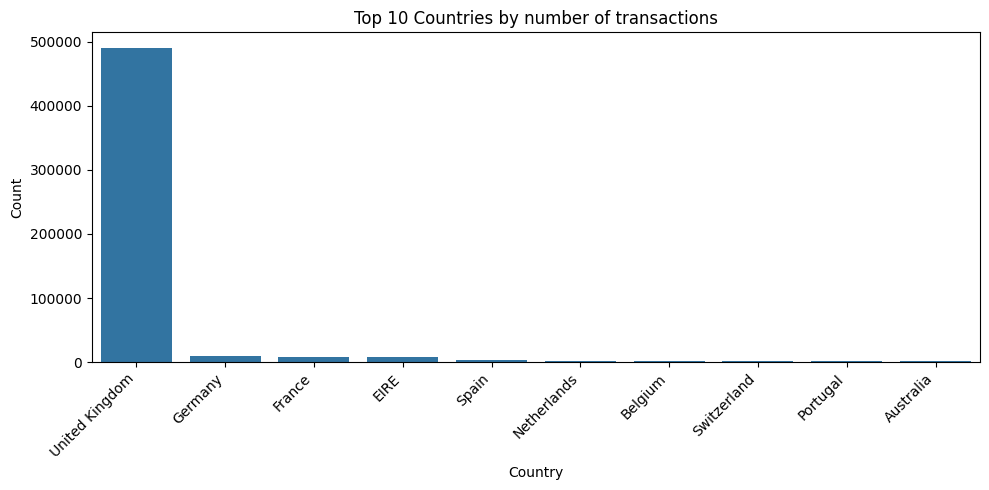

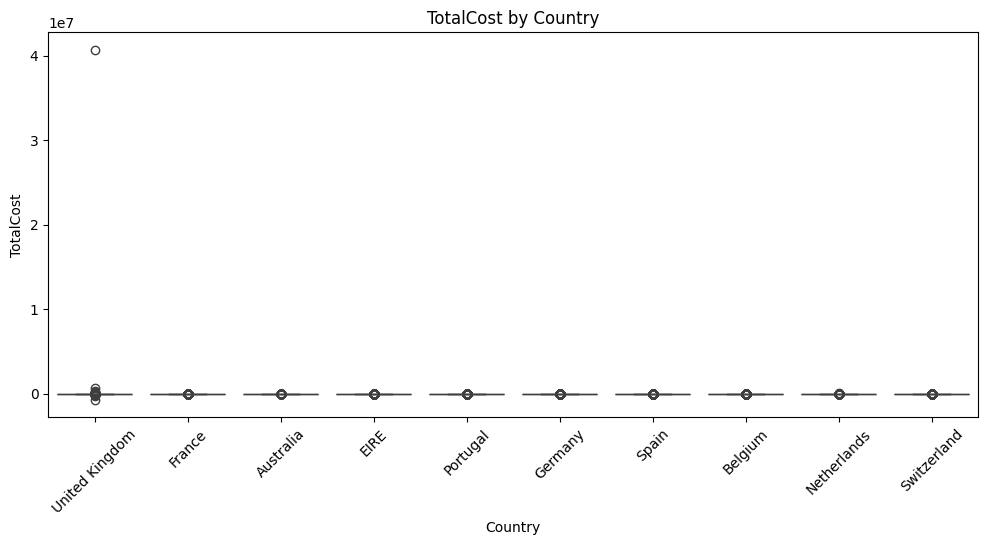

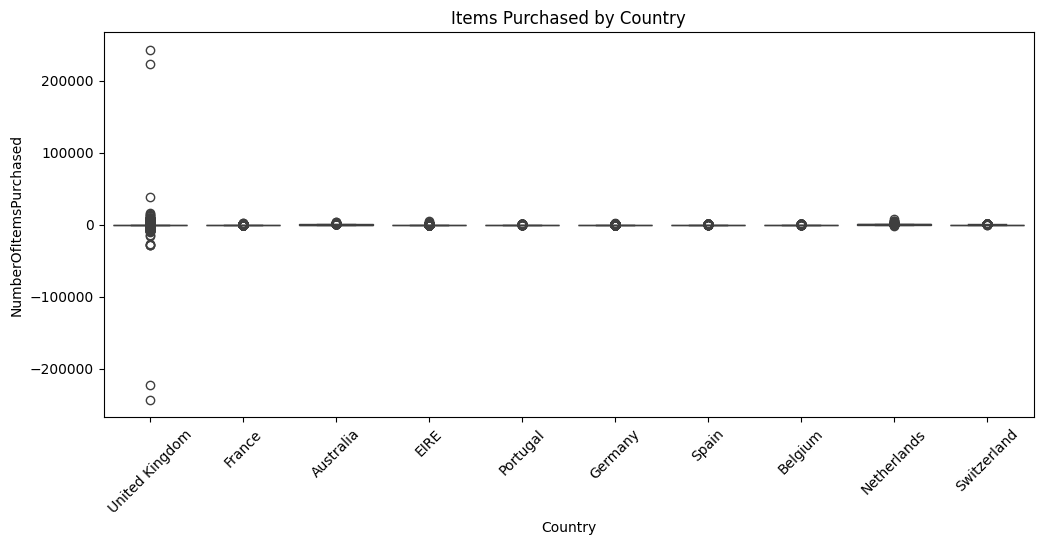

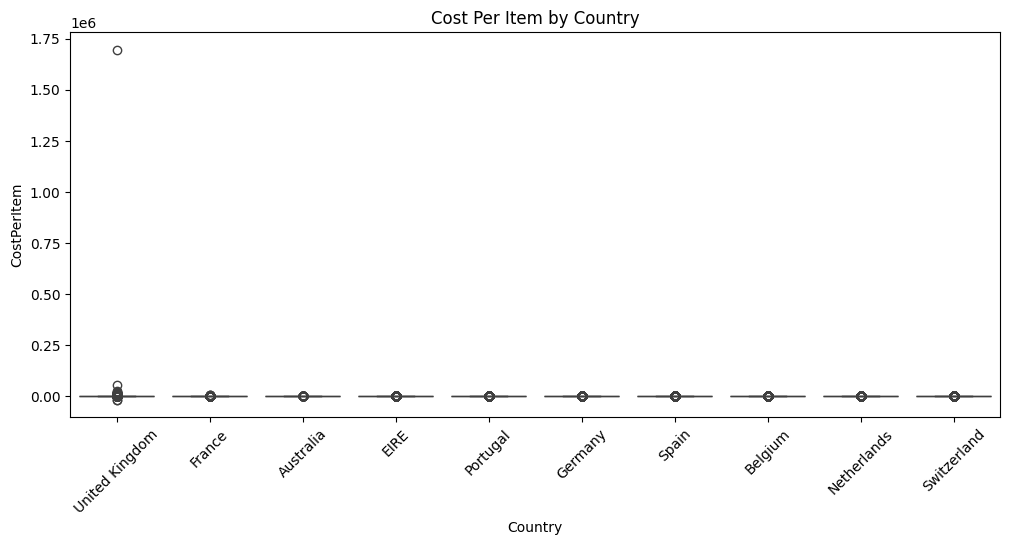

In [4]:
# EDA

# country_idx_to_name = {i: name for i, name in enumerate(le_country.classes_)}
# df_new['Country'] = df_new['Country'].map(country_idx_to_name)
#ChatGPT assessted
plt.figure(figsize=(10,5))
top_countries = df_new['Country'].value_counts().head(10)
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.title("Top 10 Countries by number of transactions")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Count")
plt.xlabel("Country")
plt.tight_layout()
plt.show()

# Boxplots
top_countries = df_new["Country"].value_counts().head(10).index
df_top = df_new[df_new["Country"].isin(top_countries)]

# TotalCost vs Country
plt.figure(figsize=(12,5))
sns.boxplot(x="Country", y="TotalCost", data=df_top)
plt.xticks(rotation=45)
plt.title("TotalCost by Country")
plt.show()

# NumberOfItemsPurchased vs Country
plt.figure(figsize=(12,5))
sns.boxplot(x="Country", y="NumberOfItemsPurchased", data=df_top)
plt.xticks(rotation=45)
plt.title("Items Purchased by Country")
plt.show()

# CostPerItem vs Country
plt.figure(figsize=(12,5))
sns.boxplot(x="Country", y="CostPerItem", data=df_top)
plt.xticks(rotation=45)
plt.title("Cost Per Item by Country")
plt.show()


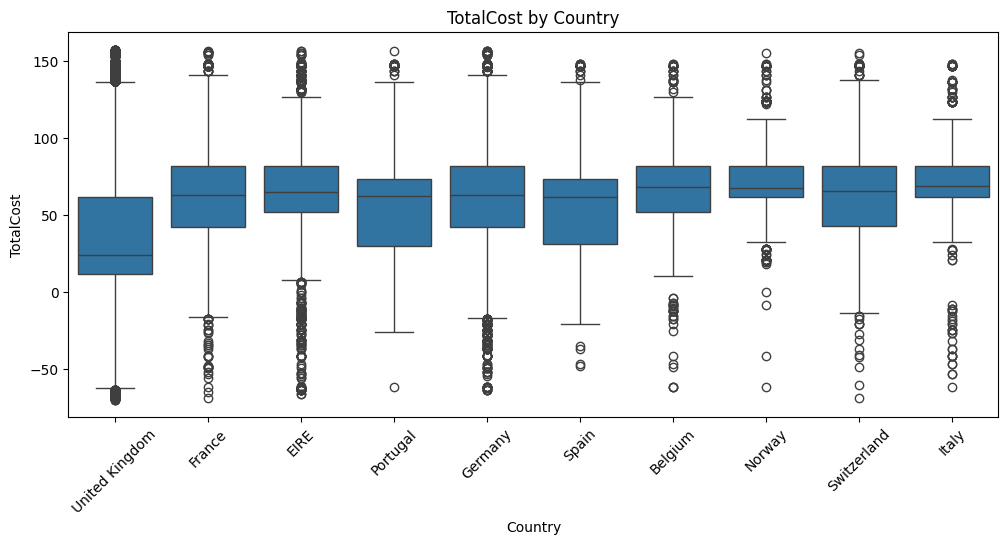

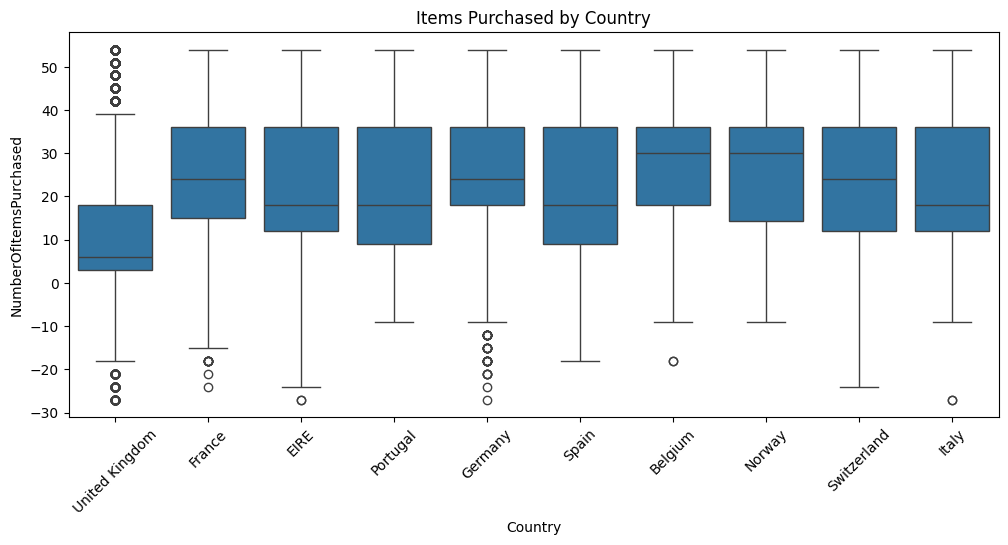

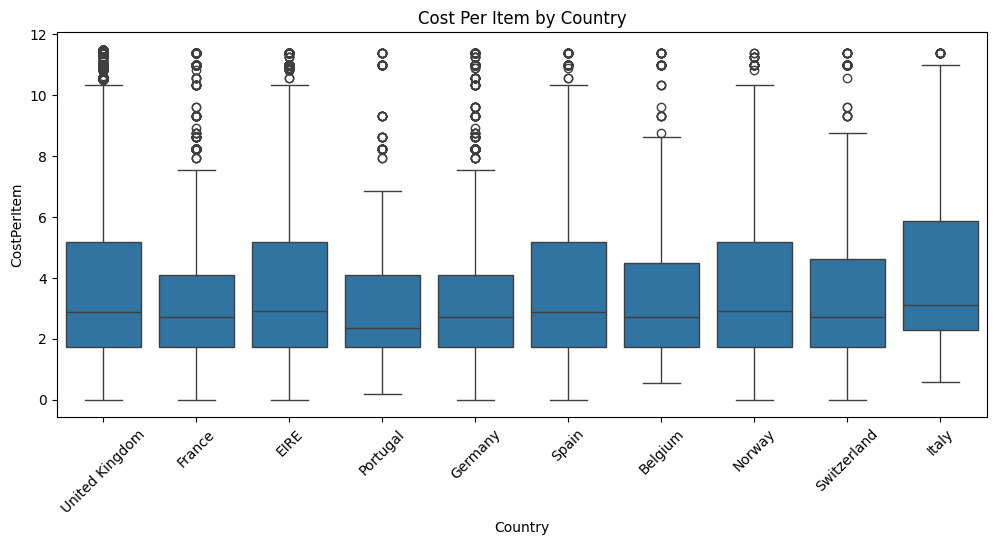

In [5]:
# Remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

cols = ["TotalCost", "NumberOfItemsPurchased", "CostPerItem"]

for col in cols:
    df_new = remove_outliers(df_new, col)

# Boxplots
top_countries = df_new["Country"].value_counts().head(10).index
df_top = df_new[df_new["Country"].isin(top_countries)]

# TotalCost vs Country
plt.figure(figsize=(12,5))
sns.boxplot(x="Country", y="TotalCost", data=df_top)
plt.xticks(rotation=45)
plt.title("TotalCost by Country")
plt.show()

# NumberOfItemsPurchased vs Country
plt.figure(figsize=(12,5))
sns.boxplot(x="Country", y="NumberOfItemsPurchased", data=df_top)
plt.xticks(rotation=45)
plt.title("Items Purchased by Country")
plt.show()

# CostPerItem vs Country
plt.figure(figsize=(12,5))
sns.boxplot(x="Country", y="CostPerItem", data=df_top)
plt.xticks(rotation=45)
plt.title("Cost Per Item by Country")
plt.show()

# I dont need the country to avoid the overfitting
df_new = df_new.drop(columns=["Country"])


In [6]:
# feature engineering section
colums = ['TotalCost', 'NumberOfItemsPurchased', 'CostPerItem']
X_before= df_new[colums]
scaler = StandardScaler()
X_after = scaler.fit_transform(X_before)
print('------------------------Scaler----------------------------')
print(X_after)
normalization=MinMaxScaler()
X_after_norm=normalization.fit_transform(X_before)
print('---------------------Normalization------------------------')
print(X_after_norm)

------------------------Scaler----------------------------
[[-0.84290316 -0.85029541 -0.05539994]
 [-1.00647643 -0.85029541 -0.73789955]
 [-0.85386897 -0.85029541 -0.10115411]
 ...
 [ 1.08890629 -0.36705482  1.73663814]
 [-0.17764428 -0.12543452 -0.3680534 ]
 [ 1.43981207  0.11618577  0.7758007 ]]
---------------------Normalization------------------------
[[0.3531122  0.37037037 0.30608696]
 [0.32945685 0.37037037 0.15043478]
 [0.35152636 0.37037037 0.29565217]
 ...
 [0.63248315 0.44444444 0.71478261]
 [0.44931941 0.48148148 0.23478261]
 [0.68322981 0.51851852 0.49565217]]


k=10, silhouette=0.0949
k=11, silhouette=0.0659
k=12, silhouette=0.0717
k=13, silhouette=0.0923
k=14, silhouette=0.1096
k=15, silhouette=0.0713
k=16, silhouette=0.0784
k=17, silhouette=0.0871
k=18, silhouette=0.0667
k=19, silhouette=0.0801
k=20, silhouette=0.0840
k=21, silhouette=0.1180
k=22, silhouette=0.1053
k=23, silhouette=0.1050
k=24, silhouette=0.0665
k=25, silhouette=0.1037
k=26, silhouette=0.1021
k=27, silhouette=0.1204
k=28, silhouette=0.1024
k=29, silhouette=0.1052
k=30, silhouette=0.1262
k=31, silhouette=0.1024
k=32, silhouette=0.1045
k=33, silhouette=0.1153
k=34, silhouette=0.1381
k=35, silhouette=0.1157
k=36, silhouette=0.1256
k=37, silhouette=0.1326
k=38, silhouette=0.1416
k=39, silhouette=0.1227
k=40, silhouette=0.1316
k=41, silhouette=0.1177
k=42, silhouette=0.1346
k=43, silhouette=0.1329
k=44, silhouette=0.1275
k=45, silhouette=0.1276
k=46, silhouette=0.1252
k=47, silhouette=0.1403
k=48, silhouette=0.1499
k=49, silhouette=0.1517
k=50, silhouette=0.1287
k=51, silhouette

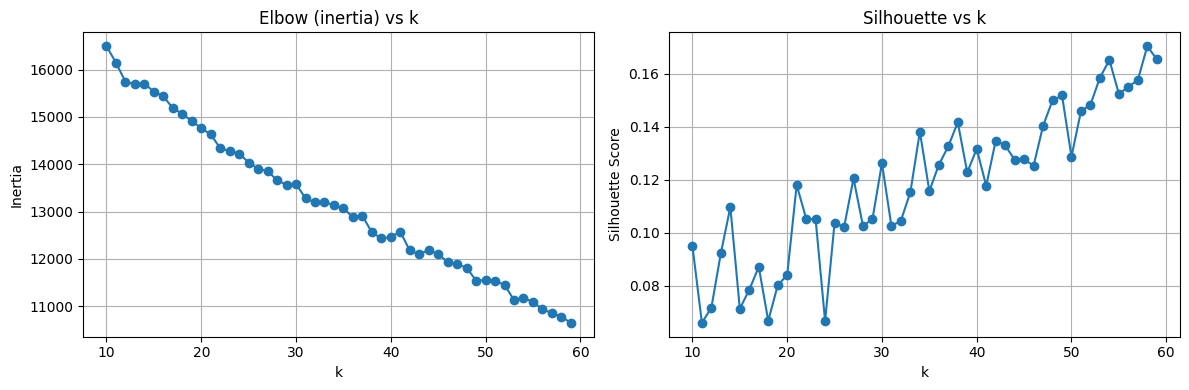

Silhouette scores: [np.float64(0.09490650996723554), np.float64(0.06590823825377704), np.float64(0.07168678728060977), np.float64(0.09225095814616362), np.float64(0.10960049219988091), np.float64(0.07126253523406881), np.float64(0.07841844289215996), np.float64(0.08707844534170117), np.float64(0.06667276938892605), np.float64(0.08008939491131184), np.float64(0.08401998462826844), np.float64(0.1179545217826294), np.float64(0.10530108889948063), np.float64(0.10495064632627098), np.float64(0.06653342468994006), np.float64(0.10372398199345002), np.float64(0.10205913141420374), np.float64(0.12041931013729097), np.float64(0.10243812362686497), np.float64(0.10515084539405502), np.float64(0.12620344869463185), np.float64(0.1023769529913155), np.float64(0.10453304544151298), np.float64(0.11526814198221252), np.float64(0.13807773232582962), np.float64(0.11566746610369658), np.float64(0.12556584144283553), np.float64(0.1325844831447838), np.float64(0.14159189450655726), np.float64(0.1227116345159

In [7]:
#ChatGPT assessted
N = df_new.shape[0]
sample_size_for_k = 40000
sample_idx = np.random.RandomState(42).choice(N, size=min(sample_size_for_k, N), replace=False)#ChatGPT assessted

tf = TfidfVectorizer(stop_words='english',
                     max_features=5000,
                     ngram_range=(1,2))

X_text = tf.fit_transform(df_new['Description'].astype(str))
num_cols = ['TotalCost', 'NumberOfItemsPurchased', 'CostPerItem']
# X_sparse = sparse.csr_matrix(X_after)

# To compare normalization path
X_sparse = sparse.csr_matrix(X_after_norm)
X_combined = hstack([X_text, X_sparse], format='csr')

# SVD reduction

svd = TruncatedSVD(n_components=150, random_state=42)

X_reduced = svd.fit_transform(X_combined)

#K-search
X_reduced_sample = X_reduced[sample_idx]

Ks = list(range(10, 60))
inertias = []
silhouettes = []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, max_iter=100, n_init=3)
    labels = km.fit_predict(X_reduced_sample)
    inertias.append(km.inertia_)
    # silhouette
    sil = silhouette_score(X_reduced_sample, labels, metric='euclidean', sample_size=10000, random_state=42)
    silhouettes.append(sil)
    print(f"k={k}, silhouette={sil:.4f}")

# Plot results
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(Ks, inertias, marker='o')
plt.title("Elbow (inertia) vs k")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(Ks, silhouettes, marker='o')
plt.title("Silhouette vs k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.tight_layout()
plt.show()

print("Silhouette scores:", silhouettes)


In [8]:
from sklearn.cluster import KMeans
# based on silhouette there are several points but 56 the best fit and in elbow there is no elbow
K = 56

kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_reduced)


df_new['Cluster'] = labels
print(labels)


[ 2 16 35 ... 14  2 14]


In [9]:
#ChatGPT assessted
for c in range(K):
    print(f"\n====== CLUSTER {c} ======")
    cluster_df = df_new[df_new['Cluster'] == c]

    if (len(cluster_df)<8):
      n=len(cluster_df)
    else:
      n=8

    sample = cluster_df.sample(n, random_state=42)
    display(sample[['Description','TotalCost','NumberOfItemsPurchased']])



====== CLUSTER 0 ======


,Description,TotalCost,NumberOfItemsPurchased
691962,poppy s playhouse livingroom,17.10,3
184176,poppy s playhouse bedroom,17.40,6
985110,poppy s playhouse kitchen,17.40,6
319704,poppy s playhouse livingroom,52.20,18
275458,poppy s playhouse bedroom,13.65,3
39004,poppy s playhouse kitchen,8.70,3
17701,poppy s playhouse kitchen,13.65,3
400971,poppy s playhouse kitchen,17.10,3



====== CLUSTER 1 ======


,Description,TotalCost,NumberOfItemsPurchased
32412,jumbo bag red retrospot,34.56,12
283418,set 5 red retrospot lid glass bowls,73.44,18
484223,set 5 red retrospot lid glass bowls,73.44,18
571012,red retrospot sugar jam bowl,63.36,18
560679,tea bag plate red retrospot,6.75,3
72515,red retrospot small milk jug,21.12,6
23240,red retrospot picnic bag,12.24,3
624000,jumbo bag red retrospot,81.00,30



====== CLUSTER 2 ======


,Description,TotalCost,NumberOfItemsPurchased
66370,heart ivory trellis large,13.65,3
271791,toast its best mum,10.20,3
377746,set of 12 rose botanical t lights,36.72,9
50394,pink doughnut trinket pot,13.65,3
517230,decorative cats bathroom bottle,10.20,3
137158,local cafe mug,8.70,3
440102,wooden happy birthday garland,24.48,6
485517,4 rose pink dinner candles,10.20,3



====== CLUSTER 3 ======


,Description,TotalCost,NumberOfItemsPurchased
139963,paper bunting vintage paisley,12.24,3
569025,paper bunting retrospot,24.48,3
310748,paper bunting retrospot,24.48,6
755200,paper bunting vintage paisley,73.44,18
263382,spotty bunting,143.64,21
208078,spotty bunting,61.56,9
200921,pink baby bunting,61.20,15
177784,pink baby bunting,122.40,30



====== CLUSTER 4 ======


,Description,TotalCost,NumberOfItemsPurchased
13329,herb marker basil,32.40,36
42621,herb marker rosemary,16.20,18
691035,set of 4 knick knack tins doiley,103.14,18
48936,set of 4 knick knack tins london,17.19,3
527235,herb marker rosemary,32.40,36
281558,herb marker thyme,2.70,3
522843,set of 4 knick knack tins leaf,-34.38,-6
180656,set of 4 knick knack tins doiley,103.14,18



====== CLUSTER 5 ======


,Description,TotalCost,NumberOfItemsPurchased
287131,hot baths metal sign,143.85,21
571550,metal sign drop your pants,71.82,18
365291,beware of the cat metal sign,84.24,36
91872,gin tonic diet metal sign,126.72,36
305356,metal sign take it or leave it,73.44,18
142943,metal sign take it or leave it,73.44,18
62594,chocolate this way metal sign,104.40,36
326269,man flu metal sign,104.40,36



====== CLUSTER 6 ======


,Description,TotalCost,NumberOfItemsPurchased
440059,jumbo bag toys,8.10,3
516265,jumbo bag baroque black white,32.40,12
221993,jumbo bag baroque black white,81.00,30
419939,jumbo bag baroque black white,25.92,9
670761,jumbo bag pink vintage paisley,8.64,3
47404,vintage doily jumbo bag red,86.40,30
81213,jumbo bag 50 s christmas,86.40,30
153926,jumbo bag pears,17.28,6



====== CLUSTER 7 ======


,Description,TotalCost,NumberOfItemsPurchased
859710,feltcraft cushion owl,15.54,3
247690,spotty pink duck doorstop,17.61,3
991002,boom box speaker girls,51.30,9
55331,white square table clock,20.55,3
576929,green vintage earrings,17.19,3
757163,magic garden felt garland,17.10,3
860195,edwardian parasol natural,24.66,3
420789,pack of 6 pannetone gift boxes,20.55,3



====== CLUSTER 8 ======


,Description,TotalCost,NumberOfItemsPurchased
179987,assorted colour bird ornament,56.16,24
854480,assorted colour bird ornament,56.16,24
223093,assorted colour bird ornament,112.32,48
296098,assorted colour bird ornament,112.32,48
332174,assorted colour bird ornament,56.16,24
559694,assorted colour bird ornament,112.32,48
48575,assorted colour bird ornament,56.16,24
165341,assorted colour bird ornament,14.04,6



====== CLUSTER 9 ======


,Description,TotalCost,NumberOfItemsPurchased
740342,dolly girl childrens cup,41.52,24
113294,childrens cutlery dolly girl,68.76,12
43304,dolly girl lunch box,97.20,36
364578,lunch bag dolly girl design,13.68,6
313710,dolly girl lunch box,32.40,12
732068,dolly girl childrens egg cup,62.28,36
296367,children s apron dolly girl,17.40,6
604470,dolly girl lunch box,17.10,3



====== CLUSTER 10 ======


,Description,TotalCost,NumberOfItemsPurchased
68747,paper chain kit 50 s christmas,109.80,12
481401,paper chain kit retrospot,72.00,9
398962,paper chain kit 50 s christmas,12.24,3
786819,paper chain kit 50 s christmas,24.48,6
215140,paper chain kit empire,73.44,18
123016,paper chain kit vintage christmas,72.00,9
141821,paper chain kit 50 s christmas,73.44,18
120904,paper chain kit 50 s christmas,73.44,18



====== CLUSTER 11 ======


,Description,TotalCost,NumberOfItemsPurchased
74110,home sweet home hanging heart,17.28,6
596090,home sweet home key holder,103.56,12
261310,home sweet home metal sign,12.24,3
53332,home sweet home mug,31.14,18
239696,home sweet home 2 drawer cabinet,82.08,12
427328,magnets pack of 4 home sweet home,19.44,36
135832,home sweet home key holder,51.78,6
852544,home sweet home mug,82.08,36



====== CLUSTER 12 ======


,Description,TotalCost,NumberOfItemsPurchased
224837,plasters in tin strongman,6.84,3
479715,plasters in tin woodland animals,13.68,6
584838,plasters in tin skulls,13.92,3
135918,plasters in tin strongman,20.52,9
925274,plasters in tin circus parade,82.08,36
307296,plasters in tin woodland animals,20.52,9
53272,plasters in tin skulls,13.65,3
607912,plasters in tin vintage paisley,41.04,18



====== CLUSTER 13 ======


,Description,TotalCost,NumberOfItemsPurchased
134965,set of 4 pantry jelly moulds,5.19,3
371963,set of 4 pantry jelly moulds,5.19,3
122083,set of 4 pantry jelly moulds,62.28,36
842949,set of 4 pantry jelly moulds,62.28,36
48182,set of 4 pantry jelly moulds,30.60,9
338554,set of 4 pantry jelly moulds,20.40,6
576650,set of 4 pantry jelly moulds,10.38,6
376488,set of 4 pantry jelly moulds,49.20,24



====== CLUSTER 14 ======


,Description,TotalCost,NumberOfItemsPurchased
492895,vintage donkey tail game,93.24,18
262082,red kukui coconut seed necklace,98.64,12
191170,vintage union jack cushion cover,82.08,12
478233,mistletoe heart wreath green,103.14,18
202127,bicycle saftey wall art,98.64,12
911665,red toadstool led night light,119.70,21
578437,dog licence wall art,98.64,12
140078,recycling bag retrospot,102.75,15



====== CLUSTER 15 ======


,Description,TotalCost,NumberOfItemsPurchased
56575,hanging heart jar t light holder,62.28,36
436647,star t light holder willie winkie,-6.84,-3
603301,hanging heart zinc t light holder,8.64,3
538299,zinc t light holder star large,15.84,12
592090,single heart zinc t light holder,17.28,6
610571,silver hanging t light holder,41.04,18
152815,assorted colour t light holder,32.40,36
72038,multi colour silver t light holder,42.48,36



====== CLUSTER 16 ======


,Description,TotalCost,NumberOfItemsPurchased
4991,key fob back door,5.40,6
592768,felt toadstool small,13.50,6
253171,pink blue felt craft trinket box,10.38,6
569568,small heart measuring spoons,3.54,3
191466,christmas tree painted zinc,7.83,9
1101,pack of 12 red retrospot tissues,1.23,3
272176,kittens design flannel,6.75,3
749087,tub 24 pink flower pegs,6.84,3



====== CLUSTER 17 ======


,Description,TotalCost,NumberOfItemsPurchased
82869,lunch bag black skull,68.40,30
818746,lunch bag black skull,34.20,6
142703,lunch bag black skull,17.10,3
275732,lunch bag black skull,68.40,30
171317,lunch bag black skull,20.52,9
455728,lunch bag black skull,68.40,30
66182,lunch bag black skull,68.40,30
25296,lunch bag black skull,68.40,30



====== CLUSTER 18 ======


,Description,TotalCost,NumberOfItemsPurchased
73824,polkadot mug pink,13.92,3
268809,pink polkadot plate,40.95,9
55624,milk pan blue polkadot,27.84,6
291112,blue polkadot beaker,40.50,18
328764,set 10 blue polkadot party candles,10.20,3
183754,set 10 blue polkadot party candles,10.38,6
879739,blue polkadot cup,28.32,24
10478,set 10 pink polkadot party candles,15.57,9



====== CLUSTER 19 ======


,Description,TotalCost,NumberOfItemsPurchased
544595,french blue metal door sign 4,51.90,30
8769,french blue metal door sign 2,30.60,9
222061,french garden sign blue metal,62.28,36
362700,french bathroom sign blue metal,82.08,36
102367,french blue metal door sign 6,10.20,3
306385,french toilet sign blue metal,10.20,3
46139,french wc sign blue metal,25.95,15
318562,french blue metal door sign 8,25.95,15



====== CLUSTER 20 ======


,Description,TotalCost,NumberOfItemsPurchased
49799,lunch box i love london,69.72,12
554311,photo frame cornice,97.92,24
908768,abc treasure book box,74.64,24
885302,small glass heart trinket pot,69.60,24
310662,yellow easter egg hunt start post,48.60,18
510736,woodland height chart stickers,73.44,18
299465,embossed heart trinket box,51.84,18
106638,photo frame cornice,97.92,24



====== CLUSTER 21 ======


,Description,TotalCost,NumberOfItemsPurchased
690164,party bunting,82.08,12
789469,party bunting,123.12,18
205981,tea time party bunting,77.04,12
31874,party bunting,82.08,12
26352,tea time party bunting,82.08,12
49588,tea time party bunting,41.04,6
201240,party bunting,20.52,3
595414,party bunting,82.08,12



====== CLUSTER 22 ======


,Description,TotalCost,NumberOfItemsPurchased
579476,vintage union jack apron,57.60,6
458409,large antique white photo frame,130.92,12
631174,wood 2 drawer cabinet white finish,28.80,3
569476,feltcraft cushion butterfly,61.80,6
683767,doormat red retrospot,34.17,3
60597,doormat black flock,34.17,3
114459,set of 4 knick knack tins london,68.70,6
389562,multicolour spring flower mug,34.35,3



====== CLUSTER 23 ======


,Description,TotalCost,NumberOfItemsPurchased
302496,alarm clock bakelike orange,46.62,9
516328,alarm clock bakelike red,15.54,3
316015,alarm clock bakelike red,124.32,24
344152,alarm clock bakelike red,124.32,24
238870,alarm clock bakelike green,124.32,24
621527,alarm clock bakelike red,30.90,3
23805,alarm clock bakelike orange,62.16,12
810472,alarm clock bakelike pink,62.16,12



====== CLUSTER 24 ======


,Description,TotalCost,NumberOfItemsPurchased
258121,traditional wooden catch cup game,62.28,36
217296,christmas metal tags assorted,42.48,36
45262,set of 12 fairy cake baking cases,27.60,24
471619,silver hearts table decoration,41.40,36
157812,wood stamp set thank you,41.40,36
229895,medium ceramic top storage jar,62.28,36
738040,strawberry ceramic trinket box,62.28,36
136993,jam jar with pink lid,42.48,36



====== CLUSTER 25 ======


,Description,TotalCost,NumberOfItemsPurchased
348359,hen house decoration,13.68,6
150556,heart decoration rustic hanging,20.16,18
672883,decoration butterfly magic garden,13.50,6
255221,ivory hanging decoration bird,28.32,24
194990,heart decoration rustic hanging,0.81,3
146649,3 hearts hanging decoration rustic,97.92,24
308279,easter decoration hanging bunny,13.50,15
892550,swallow wooden christmas decoration,3.54,3



====== CLUSTER 26 ======


,Description,TotalCost,NumberOfItemsPurchased
205678,white hanging heart t light holder,73.44,18
759169,white hanging heart t light holder,24.48,6
242947,white hanging heart t light holder,73.44,18
224246,red hanging heart t light holder,-24.48,-6
367730,red hanging heart t light holder,24.00,3
297868,white hanging heart t light holder,73.44,18
199611,white hanging heart t light holder,146.88,36
299514,white hanging heart t light holder,146.88,36



====== CLUSTER 27 ======


,Description,TotalCost,NumberOfItemsPurchased
598119,lunch bag apple design,-6.84,-3
203611,lunch bag cars blue,20.52,9
121530,lunch bag cars blue,20.52,9
991883,lunch bag apple design,41.04,18
184802,lunch bag woodland,68.40,30
120410,lunch bag cars blue,68.40,30
262119,lunch bag alphabet design,20.52,9
706339,lunch bag apple design,68.40,30



====== CLUSTER 28 ======


,Description,TotalCost,NumberOfItemsPurchased
205406,jumbo bag vintage christmas,17.28,6
421611,lunch bag vintage leaf design,13.68,6
22684,jumbo bag vintage leaf,8.64,3
563645,jumbo bag vintage doily,86.40,30
13872,jumbo bag vintage christmas,86.40,30
514188,lunch bag vintage leaf design,34.20,15
263892,lunch bag vintage leaf design,68.40,30
142707,lunch bag vintage leaf design,13.68,6



====== CLUSTER 29 ======


,Description,TotalCost,NumberOfItemsPurchased
742479,love hot water bottle,147.96,18
150015,grey heart hot water bottle,62.16,12
302170,charlie lola pink hot water bottle,24.00,3
362618,grey heart hot water bottle,52.83,9
201592,hot water bottle keep calm,41.04,6
77397,retrospot heart hot water bottle,-61.56,-9
782765,chick grey hot water bottle,57.24,12
230893,bird house hot water bottle,10.56,3



====== CLUSTER 30 ======


,Description,TotalCost,NumberOfItemsPurchased
109273,jumbo bag spaceboy design,34.20,6
808647,jumbo bag spaceboy design,8.64,3
69166,jumbo bag spaceboy design,8.64,3
229783,lunch bag spaceboy design,13.68,6
178780,lunch bag spaceboy design,61.65,9
527142,jumbo bag spaceboy design,8.64,3
367546,lunch bag spaceboy design,68.40,30
892177,lunch bag spaceboy design,68.40,30



====== CLUSTER 31 ======


,Description,TotalCost,NumberOfItemsPurchased
371319,jam making set with jars,105.66,18
173307,jam making set printed,6.03,3
132677,jam making set with jars,68.70,6
109232,jam making set printed,24.12,12
499434,jam making set printed,72.36,36
305752,jam making set with jars,105.66,18
38223,jam making set with jars,105.66,18
551393,jam making set printed,24.12,12



====== CLUSTER 32 ======


,Description,TotalCost,NumberOfItemsPurchased
393050,green regency teacup and saucer,146.88,36
261260,pink regency teacup and saucer,-24.48,-6
738659,roses regency teacup and saucer,-24.48,-6
962849,green regency teacup and saucer,48.00,6
170402,pink regency teacup and saucer,-36.72,-9
185506,green regency teacup and saucer,48.00,6
182008,roses regency teacup and saucer,24.00,3
419853,green regency teacup and saucer,73.44,9



====== CLUSTER 33 ======


,Description,TotalCost,NumberOfItemsPurchased
84980,red harmonica in box,15.57,9
350698,red harmonica in box,20.76,12
164164,red harmonica in box,10.20,3
689214,blue harmonica in box,62.28,36
464233,blue harmonica in box,62.28,36
147399,blue harmonica in box,62.28,36
169947,blue harmonica in box,20.76,12
562964,red harmonica in box,5.19,3



====== CLUSTER 34 ======


,Description,TotalCost,NumberOfItemsPurchased
167790,retrospot tea set ceramic 11 pc,41.04,6
210822,retrospot tea set ceramic 11 pc,20.52,3
71850,retrospot tea set ceramic 11 pc,61.56,9
116639,retrospot tea set ceramic 11 pc,-52.83,-9
346811,retrospot tea set ceramic 11 pc,41.04,6
442650,retrospot tea set ceramic 11 pc,41.04,6
194311,retrospot tea set ceramic 11 pc,61.56,9
141271,retrospot tea set ceramic 11 pc,123.12,18



====== CLUSTER 35 ======


,Description,TotalCost,NumberOfItemsPurchased
339988,kitchen metal sign,4.56,6
82555,washroom metal sign,18.09,9
692231,laundry 15c metal sign,10.20,3
123289,metal sign her dinner is served,12.24,3
64813,washroom metal sign,10.20,3
149173,please one person metal sign,17.10,3
864698,area patrolled metal sign,8.70,3
616629,area patrolled metal sign,8.70,3



====== CLUSTER 36 ======


,Description,TotalCost,NumberOfItemsPurchased
661360,pack of 72 retrospot cake cases,2.28,3
53139,60 teatime fairy cake cases,2.28,3
393118,60 teatime fairy cake cases,2.28,3
337751,72 sweetheart fairy cake cases,5.19,3
546088,72 sweetheart fairy cake cases,4.56,6
273782,60 cake cases dolly girl design,5.19,3
89912,60 cake cases vintage christmas,5.31,3
410200,set of 60 pantry design cake cases,22.80,30



====== CLUSTER 37 ======


,Description,TotalCost,NumberOfItemsPurchased
870556,small white heart of wicker,82.08,36
836137,heart of wicker small,40.95,9
473242,large white heart of wicker,24.48,6
34423,large white heart of wicker,12.24,3
815340,heart of wicker small,41.04,18
579229,heart of wicker large,12.24,3
598662,heart of wicker large,146.88,36
509943,small white heart of wicker,82.08,36



====== CLUSTER 38 ======


,Description,TotalCost,NumberOfItemsPurchased
180338,12 pencils tall tube woodland,10.62,9
288923,12 pencils tall tube woodland,7.08,6
167759,12 pencils tall tube posy,6.75,3
71681,12 pencils tall tube posy,6.75,3
871095,36 pencils tube red retrospot,20.40,6
1015977,12 pencils tall tube woodland,7.08,6
181229,12 pencils small tube skull,10.80,12
445051,12 pencils tall tube red retrospot,42.48,36



====== CLUSTER 39 ======


,Description,TotalCost,NumberOfItemsPurchased
563024,love building block word,73.98,9
450633,love building block word,73.98,9
16333,home building block word,73.98,9
727673,love building block word,147.96,18
308055,home building block word,25.89,3
131458,home building block word,49.32,6
363568,love building block word,49.32,6
477177,bath building block word,51.78,6



====== CLUSTER 40 ======


,Description,TotalCost,NumberOfItemsPurchased
480335,set of 3 heart cookie cutters,5.19,3
68930,set of 3 heart cookie cutters,5.19,3
656786,set of 3 butterfly cookie cutters,10.20,3
143560,set of 20 kids cookie cutters,104.40,36
493787,set of 3 butterfly cookie cutters,10.20,3
291142,set of 3 butterfly cookie cutters,20.40,6
236428,set of 3 butterfly cookie cutters,5.19,3
516550,set of 20 kids cookie cutters,104.40,36



====== CLUSTER 41 ======


,Description,TotalCost,NumberOfItemsPurchased
377439,antique silver t light glass,62.28,36
717804,antique silver t light glass,30.60,9
26395,antique glass dressing table pot,97.92,24
879623,victorian glass hanging t light,48.60,18
201148,victorian glass hanging t light,62.28,36
129824,wooden frame antique white,73.44,18
272537,victorian glass hanging t light,20.82,6
81668,victorian glass hanging t light,31.14,18



====== CLUSTER 42 ======


,Description,TotalCost,NumberOfItemsPurchased
53628,set 20 red retrospot paper napkins,21.24,18
870946,set of 20 vintage christmas napkins,3.54,3
618280,set 20 red retrospot paper napkins,6.90,6
168721,pack of 20 skull paper napkins,42.48,36
619619,pack of 20 skull paper napkins,6.75,3
347818,pack of 20 skull paper napkins,40.50,18
112167,set of 20 vintage christmas napkins,42.48,36
191923,pack of 20 napkins red apples,13.80,6



====== CLUSTER 43 ======


,Description,TotalCost,NumberOfItemsPurchased
393570,natural slate heart chalkboard,48.96,12
713701,natural slate heart chalkboard,73.44,18
159019,natural slate heart chalkboard,73.44,18
268021,natural slate heart chalkboard,24.48,6
964448,natural slate rectangle chalkboard,40.95,9
563261,natural slate heart chalkboard,24.00,3
717630,natural slate heart chalkboard,-12.24,-3
104248,natural slate chalkboard large,123.12,18



====== CLUSTER 44 ======


,Description,TotalCost,NumberOfItemsPurchased
168415,ceramic pirate chest money bank,72.36,36
1055616,pantry magnetic shopping list,72.36,36
614943,paint your own canvas set,82.08,36
61425,funky washing up gloves assorted,104.40,36
213539,6 ribbons rustic charm,97.20,36
657447,red toadstool led night light,82.08,36
110729,travel sewing kit,68.40,30
41159,bundle of 3 alphabet exercise books,82.08,36



====== CLUSTER 45 ======


,Description,TotalCost,NumberOfItemsPurchased
849880,rex cash carry jumbo shopper,7.92,6
312485,rex cash carry jumbo shopper,7.92,6
225114,rex cash carry jumbo shopper,3.96,3
593951,rex cash carry jumbo shopper,3.96,3
657871,rex cash carry jumbo shopper,11.88,9
755785,rex cash carry jumbo shopper,3.96,3
378010,rex cash carry jumbo shopper,7.92,6
165378,rex cash carry jumbo shopper,3.96,3



====== CLUSTER 46 ======


,Description,TotalCost,NumberOfItemsPurchased
75077,lunch bag suki design,68.40,30
144246,lunch bag suki design,68.40,30
466134,charlotte bag suki design,35.40,30
770429,charlotte bag suki design,10.62,9
126105,charlotte bag suki design,6.75,3
513735,lunch bag suki design,68.40,30
616051,lunch bag suki design,68.40,30
457415,lunch bag suki design,68.40,30



====== CLUSTER 47 ======


,Description,TotalCost,NumberOfItemsPurchased
308157,hand warmer bird design,34.80,12
212266,hand warmer bird design,104.40,36
110359,hand warmer babushka design,104.40,36
807781,hand warmer red retrospot,8.70,3
301116,hand warmer babushka design,17.40,6
154457,hand warmer babushka design,104.85,15
254066,hand warmer owl design,43.50,15
248681,hand warmer red love heart,104.40,36



====== CLUSTER 48 ======


,Description,TotalCost,NumberOfItemsPurchased
68336,pink drawer knob acrylic edwardian,62.28,36
50685,red drawer knob acrylic edwardian,62.28,36
401010,blue spot ceramic drawer knob,27.84,6
174750,drawer knob crackle glaze green,41.04,18
75302,clear drawer knob acrylic edwardian,62.28,36
335234,clear drawer knob acrylic edwardian,62.28,36
916320,blue drawer knob acrylic edwardian,46.71,27
645051,white spot red ceramic drawer knob,72.36,36



====== CLUSTER 49 ======


,Description,TotalCost,NumberOfItemsPurchased
157301,jumbo storage bag skulls,81.00,30
280564,jumbo storage bag suki,86.40,30
466672,jumbo storage bag skulls,34.20,6
199763,jumbo storage bag skulls,81.00,30
893259,jumbo storage bag suki,8.64,3
48676,jumbo storage bag skulls,41.10,6
213948,jumbo storage bag suki,16.20,6
25307,jumbo storage bag suki,17.28,6



====== CLUSTER 50 ======


,Description,TotalCost,NumberOfItemsPurchased
689093,ribbon reel making snowmen,34.20,15
123974,embroidered ribbon reel rachel,71.82,18
377144,ribbon reel stripes design,68.40,30
35861,ribbon reel socks and mittens,27.30,6
283442,ribbon reel stripes design,68.40,30
100795,ribbon reel hearts design,34.20,15
610574,ribbon reel lace design,87.00,30
473192,ribbon reel stripes design,34.20,15



====== CLUSTER 51 ======


,Description,TotalCost,NumberOfItemsPurchased
279057,spaceboy birthday card,10.62,9
772402,card circus parade,20.88,36
350993,tea party birthday card,3.45,3
266379,elephant birthday card,20.88,36
906418,fancy font birthday card,20.88,36
315087,cowboys and indians birthday card,20.88,36
226388,tea party birthday card,20.88,36
43379,booze women greeting card,20.88,36



====== CLUSTER 52 ======


,Description,TotalCost,NumberOfItemsPurchased
74126,set of 3 cake tins pantry design,41.04,6
290526,set of 3 cake tins pantry design,123.12,18
585490,set of 3 cake tins pantry design,20.52,3
664270,set of 3 cake tins pantry design,20.52,3
106293,set of 3 regency cake tins,82.08,12
340648,set of 3 cake tins pantry design,61.56,9
63996,set of 3 regency cake tins,82.08,12
678604,set of 3 regency cake tins,82.08,12



====== CLUSTER 53 ======


,Description,TotalCost,NumberOfItemsPurchased
162935,frying pan pink polkadot,140.88,24
820708,pink heart shape egg frying pan,41.04,18
204274,frying pan union flag,17.61,3
279788,egg frying pan red,8.64,3
661423,pink heart shape egg frying pan,54.72,24
723185,frying pan blue polkadot,69.60,15
53385,frying pan blue polkadot,27.84,6
154380,frying pan red retrospot,70.44,12



====== CLUSTER 54 ======


,Description,TotalCost,NumberOfItemsPurchased
184152,jumbo bag pink polkadot,17.10,3
28043,lunch bag pink polkadot,68.40,30
342482,lunch bag pink polkadot,-6.84,-3
403133,charlotte bag pink polkadot,35.40,30
152247,jumbo bag pink polkadot,17.28,6
140821,lunch bag pink polkadot,102.60,45
505686,lunch bag pink polkadot,41.10,6
168046,jumbo bag pink polkadot,86.40,30



====== CLUSTER 55 ======


,Description,TotalCost,NumberOfItemsPurchased
539319,travel card wallet union jack,6.90,6
467576,travel card wallet retro petals,10.35,9
65948,travel card wallet skulls,1.74,3
108892,travel card wallet pantry,3.45,3
487303,travel card wallet vintage ticket,17.40,30
111026,travel card wallet skulls,6.96,12
317595,travel card wallet skulls,3.45,3
198362,travel card wallet transport,17.25,15


In [10]:
# since we have the K (number of clusters) lets categorize
cluster_to_category = {
  0:"Lunch Bags (Skull / Charlotte style)",
  1:"Mixed Small Gifts (misc)",
  2:"Home Sweet Home / Hooks & Small Home Decor",
  3:"Hanging Heart / Tea-light Holders",
  4:"Paper Chain Kits / Craft Kits",
  5:"Jumbo Storage Bags",
  6:"Travel Card Wallets / Small Pouches",
  7:"Hot Water Bottles",
  8:"Jumbo / Charlotte Bags (Apples design)",
  9:"Union Jack / Flag Homeware",
  10:"Wicker Hearts (decor)",
  11:"Red Retrospot Collection",
  12:"Alarm Clocks & Clocks",
  13:"Suki / Charlotte Lunch Bags",
  14:"Regency Tea Cup & Saucers",
  15:"Vintage Leaf / Doily Bags",
  16:"Seasonal Decorations / Ornaments",
  17:"Blue / Polkadot Home Textiles",
  18:"Drawer Knobs / Cabinet Hardware",
  19:"Boxes, Storage & Recipe Boxes",
  20:"Metal Signs",
  21:"Pantry / Kitchen Sets & Doilies",
  22:"Popcorn Holders",
  23:"Cake Cases (60-set)",
  24:"Alphabet Lunch / Jumbo Bags",
  25:"Pink Polkadot Collection",
  26:"Regency Cake Stands",
  27:"Hanging / Antique Tea-lights",
  28:"Plasters / First Aid (tins)",
  29:"Christmas wrap / crackers",
  30:"Gardeners Kneeling Pads",
  31:"Heart Decorations / Zinc Heart",
  32:"Building Block Words (home/bath)",
  33:"Assorted Bird Ornaments",
  34:"No Description / NAN bucket",
  35:"Spaceboy / Themed Lunch Bags",
  36:"Vintage-style Misc",
  37:"Postage / Dotcom Postage",
  38:"Natural Slate Chalkboards",
  39:"Round Snack Boxes / Food",
  40:"Wooden Homeware & Frames",
  41:"Dolly Girl Collection",
  42:"Small Packs (tissues/pencils)",
  43:"Party Bunting",
  44:"French Blue Metal Door Signs",
  45:"Kitchen Scales",
  46:"Night Lights",
  47:"Cake Tin sets (3-piece)",
  48:"Stationery & Craft Sets",
  49:"Jumbo Bags (various)",
  50:"Ribbon Reels / Craft Ribbon",
  51:"Wall Art / Decorative Signs",
  52:"Jam Making Sets",
  53:"Pack of 72 Cake Cases",
  54:"Photo Frames",
  55:"Feltcraft / Soft Craft Kits"
}


df_new['Category'] = df_new['Cluster'].map(cluster_to_category).fillna("Unlabeled")
print(df_new['Category'].unique())

['Home Sweet Home / Hooks & Small Home Decor'
 'Seasonal Decorations / Ornaments' 'Spaceboy / Themed Lunch Bags'
 'Vintage Leaf / Doily Bags' 'Party Bunting'
 'French Blue Metal Door Signs' 'Assorted Bird Ornaments'
 'Regency Tea Cup & Saucers' 'Cake Cases (60-set)'
 'Wall Art / Decorative Signs' 'Wooden Homeware & Frames'
 'Popcorn Holders' 'Hot Water Bottles' 'Metal Signs'
 'Mixed Small Gifts (misc)' 'Paper Chain Kits / Craft Kits'
 'Travel Card Wallets / Small Pouches' 'Small Packs (tissues/pencils)'
 'Natural Slate Chalkboards' 'Dolly Girl Collection'
 'Christmas wrap / crackers' 'Alphabet Lunch / Jumbo Bags'
 'Red Retrospot Collection' 'Jam Making Sets' 'Stationery & Craft Sets'
 'Vintage-style Misc' 'Postage / Dotcom Postage' 'Regency Cake Stands'
 'Hanging / Antique Tea-lights' 'Hanging Heart / Tea-light Holders'
 'Union Jack / Flag Homeware' 'Feltcraft / Soft Craft Kits'
 'Blue / Polkadot Home Textiles' 'Jumbo Storage Bags'
 'Pantry / Kitchen Sets & Doilies' 'Photo Frames'
 'Pi

In [12]:
X_T = df_new['Description'].astype(str)
X_N = df_new[['TotalCost','NumberOfItemsPurchased','CostPerItem']].astype(float)
y = df_new['Category']

X_Ttrain, X_Ttest, X_Ntrain, X_Ntest, y_train, y_test = train_test_split(
    X_T, X_N, y, test_size=0.20, stratify=y, random_state=42
)

X_Ttrain_tf = tf.fit_transform(X_Ttrain)
X_Ttest_tf = tf.transform(X_Ttest)

X_Ttrain_svd = svd.fit_transform(X_Ttrain_tf)
X_Ttest_svd = svd.transform(X_Ttest_tf)

X_Ntrain_scaled = scaler.fit_transform(X_Ntrain)
X_Ntest_scaled = scaler.transform(X_Ntest)


X_train= np.hstack([X_Ttrain_svd, X_Ntrain_scaled])
X_test= np.hstack([X_Ttest_svd, X_Ntest_scaled])

model = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)


                                            precision    recall  f1-score   support

                     Alarm Clocks & Clocks       1.00      1.00      1.00       664
               Alphabet Lunch / Jumbo Bags       0.99      0.97      0.98      6194
                   Assorted Bird Ornaments       1.00      1.00      1.00       214
             Blue / Polkadot Home Textiles       1.00      1.00      1.00       229
             Boxes, Storage & Recipe Boxes       0.99      1.00      0.99       528
          Building Block Words (home/bath)       1.00      1.00      1.00       528
                       Cake Cases (60-set)       1.00      1.00      1.00       781
                   Cake Tin sets (3-piece)       0.98      1.00      0.99       623
                 Christmas wrap / crackers       1.00      1.00      1.00      1474
                     Dolly Girl Collection       0.94      1.00      0.97       684
           Drawer Knobs / Cabinet Hardware       0.90      1.00      0.94  

In [13]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

y_train_shuffled = np.random.permutation(y_train)#ChatGPT assessted

model.fit(X_train, y_train_shuffled)

y_pred_shuffled = model.predict(X_test)
acc = accuracy_score(y_test, y_pred_shuffled)
acc


0.004794488114404773

In [14]:
# without NLP
X_num = df_new[['TotalCost','NumberOfItemsPurchased','CostPerItem']].astype(float)
y = df_new['Category']

X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(
    X_num, y, test_size=0.20, stratify=y, random_state=42
)

X_Ntrain_scaled = scaler.fit_transform(X_train_num)
X_Ntest_scaled = scaler.transform(X_test_num)

model.fit(X_Ntrain_scaled, y_train_num)
accuracy = model.score(X_Ntest_scaled, y_test_num)
print(accuracy)


0.34113078890046405


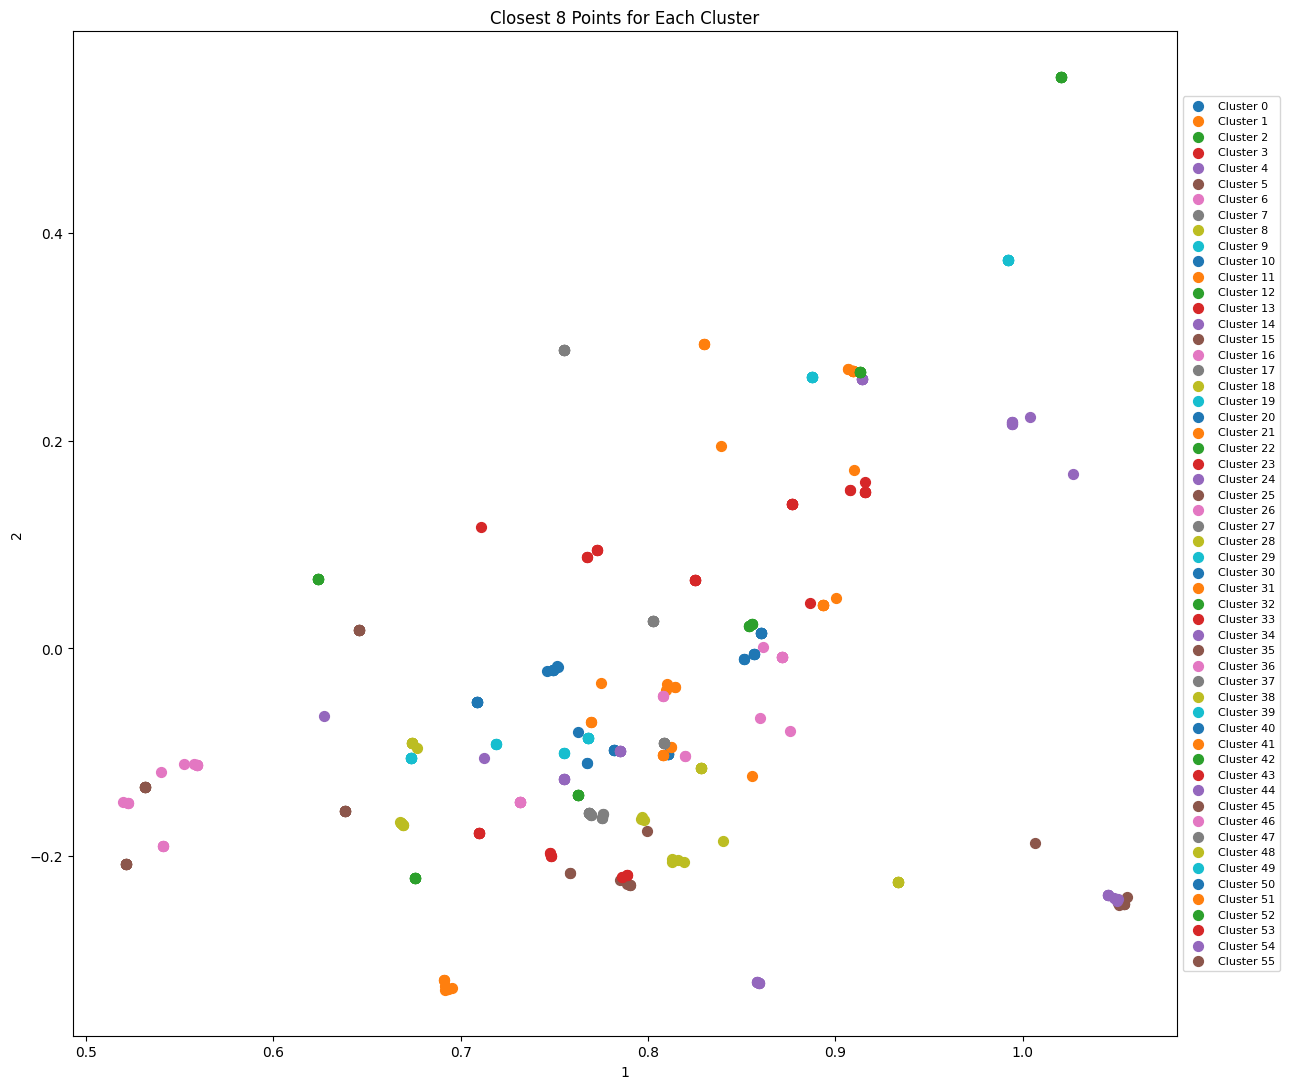

In [15]:
#ChatGPT assessted
X2 = X_reduced[:, :2]
labels = df_new['Cluster'].values

plt.figure(figsize=(13, 11))

for c in range(K):
    cluster_points = X2[labels == c]
    centroid = cluster_points.mean(axis=0)
    distances = np.linalg.norm(cluster_points - centroid, axis=1)
    idx = distances.argsort()[:8]
    close_points = cluster_points[idx]
    plt.scatter(close_points[:,0], close_points[:,1], s=50, label=f"Cluster {c}")

plt.title("Closest 8 Points for Each Cluster")
plt.xlabel("1")
plt.ylabel("2")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
plt.tight_layout()
plt.show()


In [16]:
def user_spending(user_id, df=df_new):
    res = df[df['UserId'] == user_id]
    if res.empty:
        return 'no user found with this id'
    out = res.groupby('Category', as_index=False)['TotalCost'].sum().sort_values('TotalCost', ascending=False)
    out['percenrage'] = (out['TotalCost'] / out['TotalCost'].sum())*100
    return out.head(10000000000000000000000000000000000000000000000000000000000)

# random user
print(user_spending(278166))


                                      Category  TotalCost  percenrage
26            Seasonal Decorations / Ornaments     284.22   10.598027
0                  Alphabet Lunch / Jumbo Bags     283.50   10.571179
10  Home Sweet Home / Hooks & Small Home Decor     264.12    9.848536
29         Travel Card Wallets / Small Pouches     190.08    7.087724
28                Spaceboy / Themed Lunch Bags     185.88    6.931114
23                    Postage / Dotcom Postage     136.80    5.101013
11                           Hot Water Bottles     115.23    4.296709
9            Hanging Heart / Tea-light Holders     110.16    4.107658
13                          Jumbo Storage Bags     103.68    3.866031
27               Small Packs (tissues/pencils)     102.66    3.827997
20                    Pink Polkadot Collection      99.96    3.727320
5                  Feltcraft / Soft Craft Kits      87.00    3.244066
15                                 Metal Signs      82.08    3.060608
8                 Ha